In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime

import tensorflow as tf
import tfimm

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
from PIL import Image


In [3]:
# Load your dataframe
data_dir = 'data/ODIR5K/bence/'

df = pd.read_csv(data_dir + 'train_df.csv', index_col=0)
df.set_index(["ID"], inplace=True)
df.drop(["Patient Sex"], axis=1, inplace=True)

img_dir= data_dir + 'train/'
labels = df["Patient Age"].values
image_names = df["Left-Fundus"].values
img_paths = img_dir + image_names

# Create dataset
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.image.resize(image, [224, 224])  
    image = image / 255.0 
    return image, label

def preprocess_dataset(image_names, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y))
    return dataset

train_dataset = preprocess_dataset(img_paths, labels)
batch_size = 8
train_dataset = train_dataset.batch(batch_size)
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

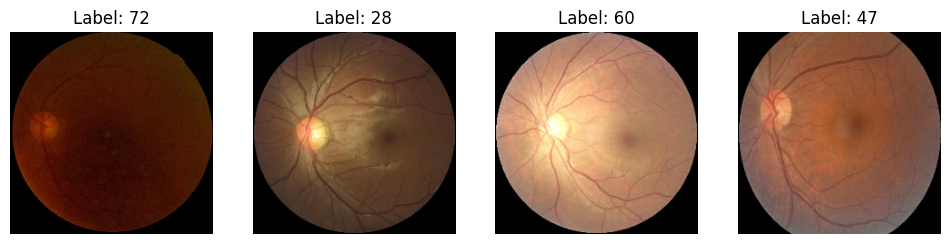

(8, 224, 224, 3)
Max pixel value: 1.0
Min pixel value: 0.0
Mean pixel value: 0.23736663
Pixel value range: 1.0


In [4]:
# visualize some images

def plot_images(images, labels, num_images=4):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()


# Get a batch of images and labels
for images, labels in train_dataset.take(1):  # Take one batch
    plot_images(images.numpy(), labels.numpy())

    # Convert images to numpy array for analysis
    images_np = images.numpy()

    # Print pixel value statistics
    print(images.shape)
    print("Max pixel value:", np.max(images_np))
    print("Min pixel value:", np.min(images_np))
    print("Mean pixel value:", np.mean(images_np))
    print("Pixel value range:", np.max(images_np) - np.min(images_np))
    break

In [5]:
# Create validation dataset
df = pd.read_csv(data_dir + 'val_df.csv', index_col=0)
df.set_index(["ID"], inplace=True)
df.drop(["Patient Sex"], axis=1, inplace=True)

img_dir= data_dir + 'val/'
labels = df["Patient Age"].values
image_names = df["Left-Fundus"].values
img_paths = img_dir + image_names

val_dataset = preprocess_dataset(img_paths, labels)
val_dataset = val_dataset.batch(batch_size)
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
# Create the base model
model_name = "vit_large_patch16_224"
base_model = tfimm.create_model(
    model_name,
    nb_classes=0  # this removes the final layer
)

# Load base_model weights (by_name=True because nb_classes=0 removes a layer)
model_path = "RETFound_CFP_weights.h5" # get from RETFound github

base_model.load_weights(model_path, by_name=True, skip_mismatch=False)
base_model.trainable = False
# base_model.summary()

# Input layer
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)

# ViT layer
x = base_model(inputs)

# Add layers to match the original architecture leading up to the 'head' layer
# x = tf.keras.layers.LayerNormalization()(x)
# x = tf.keras.layers.Dense(2048, activation='relu')(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)

x = tf.keras.layers.Dense(2048)(x) 
x = tf.keras.layers.Dropout(0.5)(x)  # Adding Dropout
x = tf.keras.layers.BatchNormalization()(x)  # Adding Batch Normalization
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding Dropout
x = tf.keras.layers.BatchNormalization()(x)  # Adding Batch Normalization
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding Dropout
x = tf.keras.layers.BatchNormalization()(x)  # Adding Batch Normalization

prediction = tf.keras.layers.Dense(1, activation='relu',name='head')(x)


# Define the model
model = tf.keras.Model(inputs=inputs, outputs=prediction)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit_large_patch16_224 (ViT)  (None, 1024)             303301632 
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dropout_97 (Dropout)        (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                             

In [ ]:
# Create the base model
model_name = "vit_large_patch16_224"
base_model = tfimm.create_model(
    model_name,
    nb_classes=0  # this removes the final layer
)

# Load base_model weights (by_name=True because nb_classes=0 removes a layer)
model_path = "RETFound_CFP_weights.h5" # get from RETFound github

base_model.load_weights(model_path, by_name=True, skip_mismatch=False)
base_model.trainable = False
# base_model.summary()

# Input layer
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)

# ViT layer
x = base_model(inputs)

# Add layers to match the original architecture leading up to the 'head' layer
# x = tf.keras.layers.LayerNormalization()(x)
# x = tf.keras.layers.Dense(2048, activation='relu')(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)

x = tf.keras.layers.Dense(2048, use_bias=False)(x) 
x = tf.keras.layers.BatchNormalization()(x)  # Adding Batch Normalization
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding Dropout

x = tf.keras.layers.Dense(1024, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)  # Adding Batch Normalization
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding Dropout

x = tf.keras.layers.Dense(1024, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)  # Adding Batch Normalization
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding Dropout

prediction = tf.keras.layers.Dense(1, activation='relu',name='head')(x)

# early stopping, patience 50 kb 
 
# felezve negyedelve a neuronok számát, h megy?

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=prediction)
model.summary()


In [8]:
epochs = 400
print("epochs: "+str(epochs))

epochs: 400


In [6]:
import tensorflow_addons as tfa
from scheduler import WarmUpCosine



num_batches = tf.data.experimental.cardinality(train_ds)
num_samples = num_batches.numpy() * batch_size
print("num_batches: "+str((tf.data.experimental.cardinality(train_ds).numpy())))
print("num_samples: "+str(num_samples))

### Set optimization parameters
steps = int((num_samples // batch_size) * epochs)
warmup_steps = int(steps * 0.1)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=5e-4,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)
print("warmup_steps: "+str(warmup_steps))
print("steps: "+str(steps))

optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=1e-4)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mean_absolute_error'])


epochs: 500
num_batches: 183
num_samples: 1464
warmup_steps: 9150
steps: 91500


In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mean_absolute_error'])

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
model.load_weights('CFPmodel_20240814-l2048-1024-1024-b8-defadam-e400.h5')

In [10]:
custommodelname ="-l2048-1024-1024-b8-defadam-e400_generalized"
print("CUSTOM NAME OF THE MODEL IS:")
print(custommodelname)

CUSTOM NAME OF THE MODEL IS:
-l2048-1024-1024-b8-defadam-e400_generalized


In [1]:
%load_ext tensorboard
# launch from console with command: tensorboard --logdir=./

In [12]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + custommodelname
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/400
183/183 [==============================] - 78s 356ms/step - loss: 39.2216 - mean_absolute_error: 39.2216 - val_loss: 66.6369 - val_mean_absolute_error: 66.6369
Epoch 2/400
183/183 [==============================] - 63s 345ms/step - loss: 32.0880 - mean_absolute_error: 32.0880 - val_loss: 31.9278 - val_mean_absolute_error: 31.9278
Epoch 3/400
183/183 [==============================] - 62s 340ms/step - loss: 21.6938 - mean_absolute_error: 21.6938 - val_loss: 13.3094 - val_mean_absolute_error: 13.3094
Epoch 4/400
183/183 [==============================] - 62s 338ms/step - loss: 10.0820 - mean_absolute_error: 10.0820 - val_loss: 10.2654 - val_mean_absolute_error: 10.2654
Epoch 5/400
183/183 [==============================] - 63s 342ms/step - loss: 9.4169 - mean_absolute_error: 9.4169 - val_loss: 8.7459 - val_mean_absolute_error: 8.7459
Epoch 6/400
183/183 [==============================] - 65s 355ms/step - loss: 9.3816 - mean_absolute_error: 9.3816 - val_loss: 8.9407 - val_mean

In [14]:
model.save_weights('CFPmodel_'+ datetime.datetime.now().strftime("%Y%m%d")+custommodelname+'.h5')

In [ ]:
tf record-al érdemes menteni a train részleteit. Tanításhoz gyorsítani, data API.